In [ ]:
import numpy as np
from skimage import filters, restoration, exposure
from skimage.util import img_as_float32
import matplotlib.pyplot as plt
from scipy import ndimage, signal
from typing import Tuple, Dict, Optional

=== 저주파 라인 검출 테스트 ===

이미지 크기: (960, 540)
데이터 범위: [0.365, 0.631]

전처리 완료

검출된 주기성 라인:
1. 주기: 5.40mm (18.0 pixels)
   주파수: 0.0556, 강도: 52.9

2. 주기: 5.40mm (18.0 pixels)
   주파수: 0.0556, 강도: 52.9

3. 주기: 2.75mm (9.2 pixels)
   주파수: 0.1093, 강도: 28.2

4. 주기: 2.75mm (9.2 pixels)
   주파수: 0.1093, 강도: 28.2

5. 주기: 3.38mm (11.2 pixels)
   주파수: 0.0889, 강도: 22.6


결과 저장: lowfreq_line_detection.png


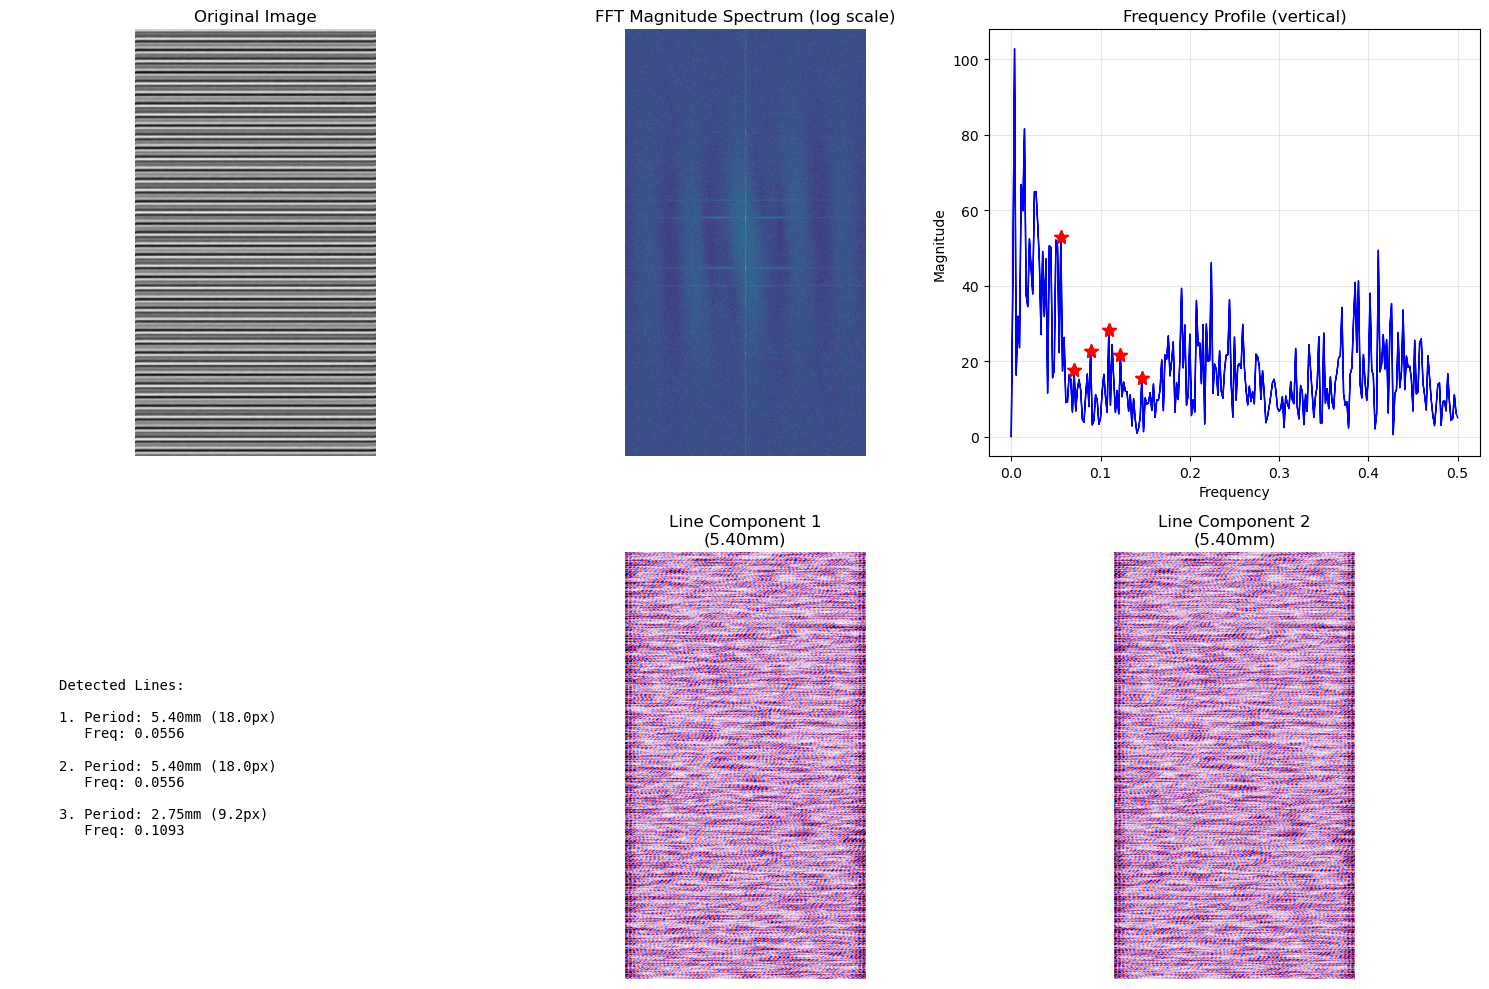

In [ ]:
class LowFreqLineDetector:
    """
    저주파 주기성 라인 검출기
    FFT 기반 주파수 분석으로 3mm, 5mm 등의 저주파 라인 패턴 검출
    """
    
    def __init__(self, pixel_size_mm: float = 0.3):
        """
        Args:
            pixel_size_mm: 픽셀당 물리적 크기 (mm)
        """
        self.pixel_size_mm = pixel_size_mm
        
    def preprocess_luminance(self, 
                            image: np.ndarray,
                            denoise: bool = True,
                            normalize: bool = True) -> np.ndarray:
        """
        휘도 데이터 전처리
        
        Args:
            image: 입력 이미지 (float32, [0, 1] 범위)
            denoise: 노이즈 제거 여부
            normalize: 정규화 여부
            
        Returns:
            전처리된 이미지
        """
        img = img_as_float32(image.copy())
        
        # 1. 이상치 제거 (클리핑)
        p1, p99 = np.percentile(img, [1, 99])
        img = np.clip(img, p1, p99)
        
        # 2. 노이즈 제거 (bilateral filter - 엣지 보존)
        if denoise:
            img = restoration.denoise_bilateral(
                img, 
                sigma_color=0.05, 
                sigma_spatial=1.5,
                channel_axis=None
            )
        
        # 3. 정규화
        if normalize:
            img = exposure.rescale_intensity(img, out_range=(0, 1))
            
        return img
    
    def compute_fft_spectrum(self, image: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        FFT 스펙트럼 계산
        
        Args:
            image: 입력 이미지
            
        Returns:
            magnitude: 주파수 크기 스펙트럼 (로그 스케일)
            phase: 위상 스펙트럼
        """
        # FFT 계산 (중심 이동)
        fft = np.fft.fft2(image)
        fft_shifted = np.fft.fftshift(fft)
        
        # 크기와 위상 분리
        magnitude = np.abs(fft_shifted)
        phase = np.angle(fft_shifted)
        
        # 로그 스케일로 변환 (시각화용)
        magnitude_log = np.log1p(magnitude)
        
        return magnitude_log, phase
    
    def detect_periodic_lines(self, 
                             image: np.ndarray,
                             direction: str = 'vertical',
                             freq_range: Tuple[float, float] = (0.05, 0.2)) -> Dict:
        """
        주기성 라인 검출
        
        Args:
            image: 전처리된 이미지
            direction: 라인 방향 ('vertical' or 'horizontal')
            freq_range: 검출할 주파수 범위 (정규화된 주파수, 0~0.5)
            
        Returns:
            검출 결과 딕셔너리
        """
        h, w = image.shape
        
        # FFT 계산
        fft = np.fft.fft2(image)
        fft_shifted = np.fft.fftshift(fft)
        magnitude = np.abs(fft_shifted)
        
        # 주파수 축 생성
        freq_y = np.fft.fftfreq(h, d=1.0)
        freq_x = np.fft.fftfreq(w, d=1.0)
        freq_y_shifted = np.fft.fftshift(freq_y)
        freq_x_shifted = np.fft.fftshift(freq_x)
        
        # 방향에 따른 1D 프로파일 추출
        center_y, center_x = h // 2, w // 2
        
        if direction == 'vertical':
            # 세로 라인 검출: x축 주파수 (수평 방향 주파수)
            profile = magnitude[center_y, :]
            freq_axis = np.abs(freq_x_shifted)
        else:
            # 가로 라인 검출: y축 주파수 (수직 방향 주파수)
            profile = magnitude[:, center_x]
            freq_axis = np.abs(freq_y_shifted)
        
        # DC 성분 제거
        dc_idx = len(profile) // 2
        profile[dc_idx] = 0
        
        # 주파수 범위 필터링
        freq_mask = (freq_axis >= freq_range[0]) & (freq_axis <= freq_range[1])
        
        # 피크 검출
        peaks, properties = signal.find_peaks(
            profile,
            prominence=np.max(profile) * 0.1,
            distance=5
        )
        
        # 주파수 범위 내 피크만 선택
        valid_peaks = peaks[freq_mask[peaks]]
        valid_freqs = freq_axis[valid_peaks]
        valid_magnitudes = profile[valid_peaks]
        
        # 피크를 크기 순으로 정렬
        sorted_indices = np.argsort(valid_magnitudes)[::-1]
        
        detected_lines = []
        for idx in sorted_indices[:5]:  # 상위 5개 피크
            freq = valid_freqs[idx]
            period_pixels = 1.0 / freq if freq > 0 else 0
            period_mm = period_pixels * self.pixel_size_mm
            
            detected_lines.append({
                'frequency': freq,
                'period_pixels': period_pixels,
                'period_mm': period_mm,
                'magnitude': valid_magnitudes[idx]
            })
        
        return {
            'detected_lines': detected_lines,
            'fft_magnitude': magnitude,
            'profile': profile,
            'freq_axis': freq_axis,
            'peaks': valid_peaks
        }
    
    def extract_line_component(self, 
                              image: np.ndarray,
                              target_freq: float,
                              direction: str = 'vertical',
                              bandwidth: float = 0.01) -> np.ndarray:
        """
        특정 주파수의 라인 성분 추출 (대역 통과 필터)
        
        Args:
            image: 입력 이미지
            target_freq: 목표 주파수
            direction: 라인 방향
            bandwidth: 주파수 대역폭
            
        Returns:
            추출된 라인 성분 이미지
        """
        h, w = image.shape
        
        # FFT 계산
        fft = np.fft.fft2(image)
        fft_shifted = np.fft.fftshift(fft)
        
        # 주파수 그리드 생성
        freq_y = np.fft.fftfreq(h, d=1.0)
        freq_x = np.fft.fftfreq(w, d=1.0)
        freq_y_grid, freq_x_grid = np.meshgrid(
            np.fft.fftshift(freq_y),
            np.fft.fftshift(freq_x),
            indexing='ij'
        )
        
        # 대역 통과 필터 생성
        if direction == 'vertical':
            freq_grid = np.abs(freq_x_grid)
        else:
            freq_grid = np.abs(freq_y_grid)
        
        bandpass_filter = np.exp(-((freq_grid - target_freq) ** 2) / (2 * bandwidth ** 2))
        bandpass_filter += np.exp(-((freq_grid + target_freq) ** 2) / (2 * bandwidth ** 2))
        
        # 필터 적용
        fft_filtered = fft_shifted * bandpass_filter
        
        # 역변환
        fft_ifft_shifted = np.fft.ifftshift(fft_filtered)
        reconstructed = np.fft.ifft2(fft_ifft_shifted)
        line_component = np.real(reconstructed)
        
        return line_component
    
    def visualize_analysis(self, 
                          image: np.ndarray,
                          result: Dict,
                          direction: str = 'vertical') -> plt.Figure:
        """
        분석 결과 시각화
        
        Args:
            image: 원본 이미지
            result: 검출 결과
            direction: 라인 방향
            
        Returns:
            matplotlib Figure 객체
        """
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # 1. 원본 이미지
        axes[0, 0].imshow(image, cmap='gray')
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')
        
        # 2. FFT 스펙트럼
        magnitude_log = np.log1p(result['fft_magnitude'])
        axes[0, 1].imshow(magnitude_log, cmap='viridis')
        axes[0, 1].set_title('FFT Magnitude Spectrum (log scale)')
        axes[0, 1].axis('off')
        
        # 3. 주파수 프로파일
        profile = result['profile']
        freq_axis = result['freq_axis']
        peaks = result['peaks']
        
        axes[0, 2].plot(freq_axis, profile, 'b-', linewidth=1)
        axes[0, 2].plot(freq_axis[peaks], profile[peaks], 'r*', markersize=10)
        axes[0, 2].set_title(f'Frequency Profile ({direction})')
        axes[0, 2].set_xlabel('Frequency')
        axes[0, 2].set_ylabel('Magnitude')
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. 검출된 라인 정보
        detected_text = "Detected Lines:\n"
        for i, line in enumerate(result['detected_lines'][:3]):
            detected_text += f"\n{i+1}. Period: {line['period_mm']:.2f}mm "
            detected_text += f"({line['period_pixels']:.1f}px)\n"
            detected_text += f"   Freq: {line['frequency']:.4f}\n"
        
        axes[1, 0].text(0.1, 0.5, detected_text, 
                       fontsize=10, verticalalignment='center',
                       family='monospace')
        axes[1, 0].axis('off')
        
        # 5-6. 상위 2개 라인 성분 추출 및 표시
        for i, (ax, line_info) in enumerate(zip(axes[1, 1:], result['detected_lines'][:2])):
            line_component = self.extract_line_component(
                image, 
                line_info['frequency'],
                direction=direction
            )
            
            ax.imshow(line_component, cmap='seismic', 
                     vmin=-np.std(line_component)*3, 
                     vmax=np.std(line_component)*3)
            ax.set_title(f'Line Component {i+1}\n({line_info["period_mm"]:.2f}mm)')
            ax.axis('off')
        
        plt.tight_layout()
        return fig


# 사용 예제
if __name__ == "__main__":
    # 샘플 이미지 생성 (테스트용)
    def generate_test_image(height=960, width=540):
        """테스트용 샘플 이미지 생성"""
        image = np.ones((height, width), dtype=np.float32) * 0.5
        
        # 3mm 라인 (10 pixels)
        period1 = 10
        for y in range(height):
            phase = (y % period1) / period1
            amplitude = 0.05 * np.sin(2 * np.pi * phase) * (0.7 + np.random.rand() * 0.6)
            image[y, :] += amplitude
        
        # 5mm 라인 (17 pixels)
        period2 = 17
        for y in range(height):
            phase = (y % period2) / period2
            amplitude = 0.04 * np.sin(2 * np.pi * phase) * (0.7 + np.random.rand() * 0.6)
            image[y, :] += amplitude
        
        # 노이즈
        image += np.random.randn(height, width) * 0.01
        
        return np.clip(image, 0, 1)
    
    # 테스트 실행
    print("=== 저주파 라인 검출 테스트 ===\n")
    
    # 이미지 생성
    test_image = generate_test_image()
    print(f"이미지 크기: {test_image.shape}")
    print(f"데이터 범위: [{test_image.min():.3f}, {test_image.max():.3f}]\n")
    
    # 검출기 초기화
    detector = LowFreqLineDetector(pixel_size_mm=0.3)
    
    # 전처리
    preprocessed = detector.preprocess_luminance(test_image, denoise=True)
    print("전처리 완료\n")
    
    # 저주파 라인 검출
    result = detector.detect_periodic_lines(
        preprocessed,
        direction='vertical',
        freq_range=(0.05, 0.15)
    )
    
    print("검출된 주기성 라인:")
    for i, line in enumerate(result['detected_lines']):
        print(f"{i+1}. 주기: {line['period_mm']:.2f}mm ({line['period_pixels']:.1f} pixels)")
        print(f"   주파수: {line['frequency']:.4f}, 강도: {line['magnitude']:.1f}\n")
    
    # 시각화
    fig = detector.visualize_analysis(preprocessed, result, direction='vertical')
    plt.savefig('lowfreq_line_detection.png', dpi=150, bbox_inches='tight')
    print("\n결과 저장: lowfreq_line_detection.png")
    plt.show()